In [1]:
import sys

import torch
import joblib
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('..')

from src.data import get_loader
from src.model import AutoEncoder
from src.train import predict
from configs.improved import model_config
from src.visualization import (plot_grid, plot_histograms, plot_pairplot, 
                               plot_3d_scatter, plot_scatter, plot_distplot)

plt.style.use('seaborn-bright')

## Load data and pretrained model

In [2]:
df_test = pd.read_pickle('../data/all_jets_test_4D_100_percent.pkl')
feature_names = df_test.columns

scaler = joblib.load('../weights/scaler.pkl')
scaled_test = scaler.transform(df_test)

loader_test = get_loader(
    scaled_test, batch_size=4000, is_train=False
)

device = torch.device('cpu')
model = AutoEncoder(model_config)
model.load_state_dict(torch.load('../weights/model.pth'))

<All keys matched successfully>

## Run autoencoder on test data

In [3]:
%%time

reconstructed, original = predict(model, device, loader_test)

CPU times: user 1.91 s, sys: 140 ms, total: 2.05 s
Wall time: 441 ms


### For analysis it would be more convinient to convert to original scale of features 

In [4]:
reconstructed_unscaled = scaler.inverse_transform(reconstructed)
original_unscaled = scaler.inverse_transform(original)

# Visualisation and Analysis

### Analysis of dependency between original and reconstructed samples

If we would have ideal autoencoder then we would see samples only on diagonal.<br>
It seems that it works pretty good because all samples lie almost on diagonal line.

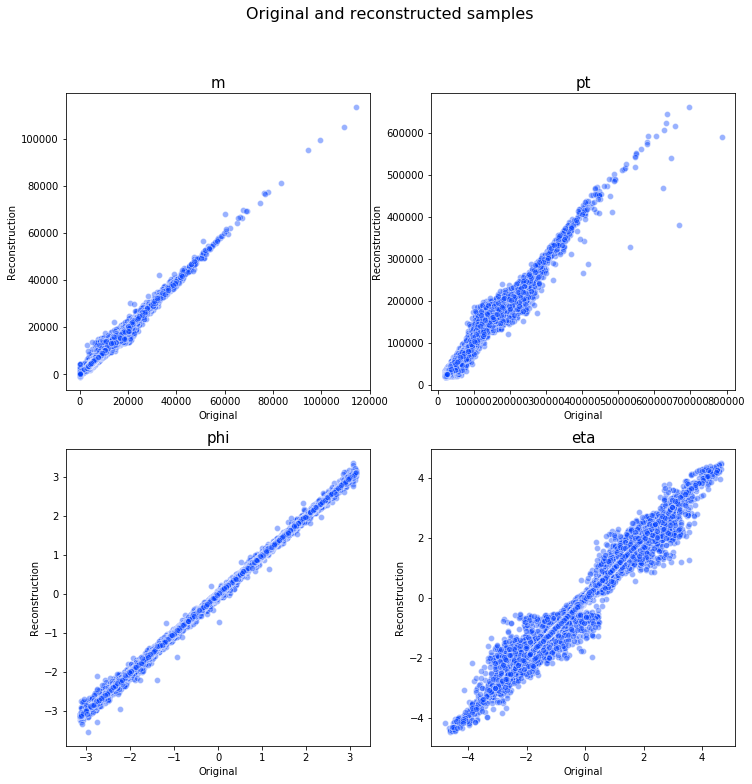

In [5]:
plot_grid(
    plot_scatter, reconstructed_unscaled, original_unscaled,
    feature_names, 'Original and reconstructed samples'
)

### Analysis of original and reconstructed distributions

As we can see, both distributions are similar to each other. It is a good sign

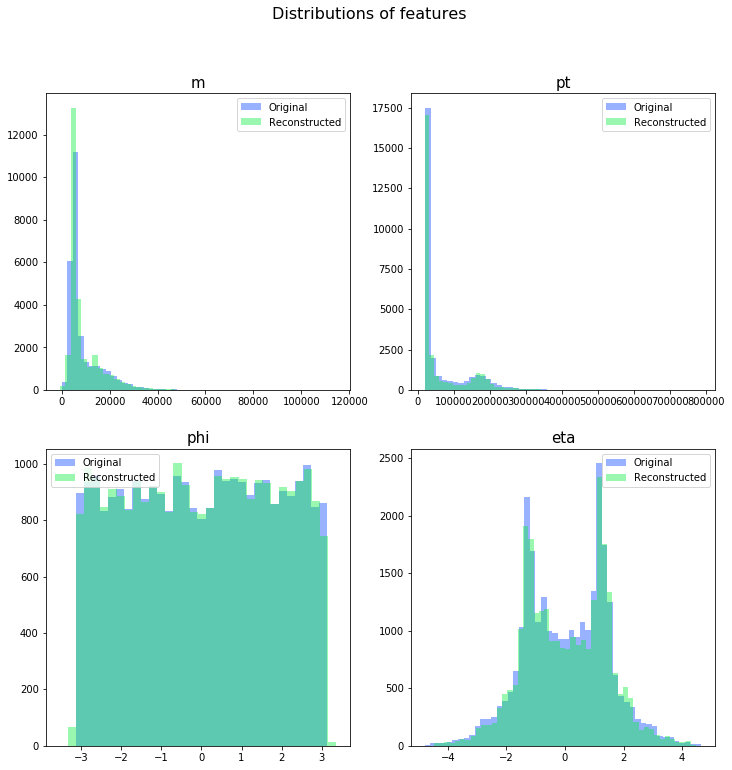

In [6]:
plot_grid(plot_distplot, reconstructed_unscaled, original_unscaled, feature_names, 'Distributions of features')

## Analyse residuals of reconstructions



In [7]:
def filter_outliers(data, i):
    """Removes samples that less than 1% and more than 99%
    Args:
        data: np.array of size(N, M)
        i: int - i < M. Index of column to filter outliers
    """ 
    q0 = np.quantile(data[:, i], 0.01)
    q0_ = np.quantile(data[:, i], 0.99)
    not_outliers = (data[:, i] > q0) & (data[:, i] < q0_)
    data = data[not_outliers]
    return data

residuals = (reconstructed_unscaled - original_unscaled) / original_unscaled
for i in range(4):
    residuals = filter_outliers(residuals, i)
residuals_df = pd.DataFrame(residuals, columns=feature_names)

### Seems that all residuals are near zero. 

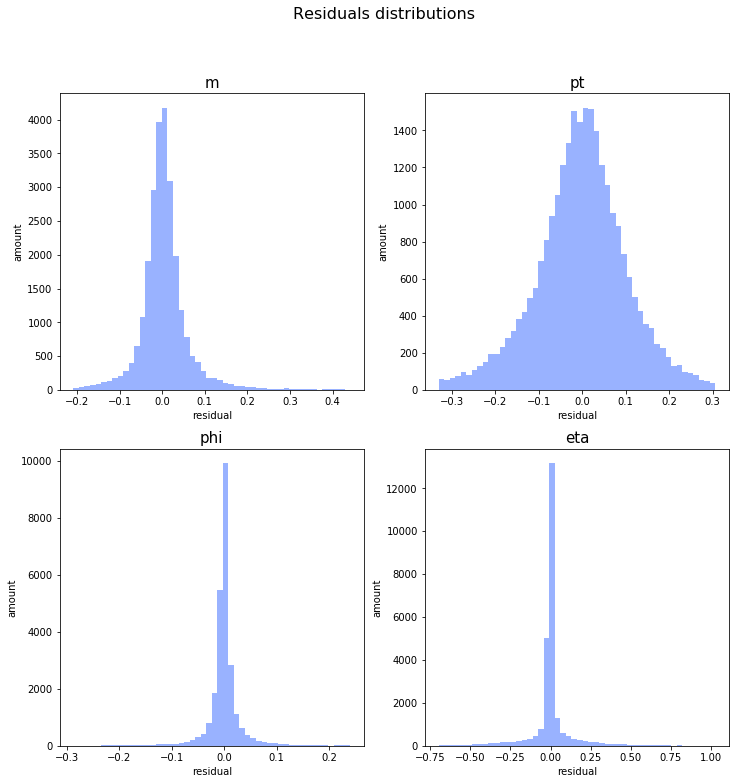

In [8]:
plot_histograms(residuals, feature_names, 'Residuals distributions')

### Let's check dependency of residuals of different features

We can see that residuals of some features slightly correlate, but `m` and `pt` have almost linear relationship! <br>
Need to investigate more on these two.

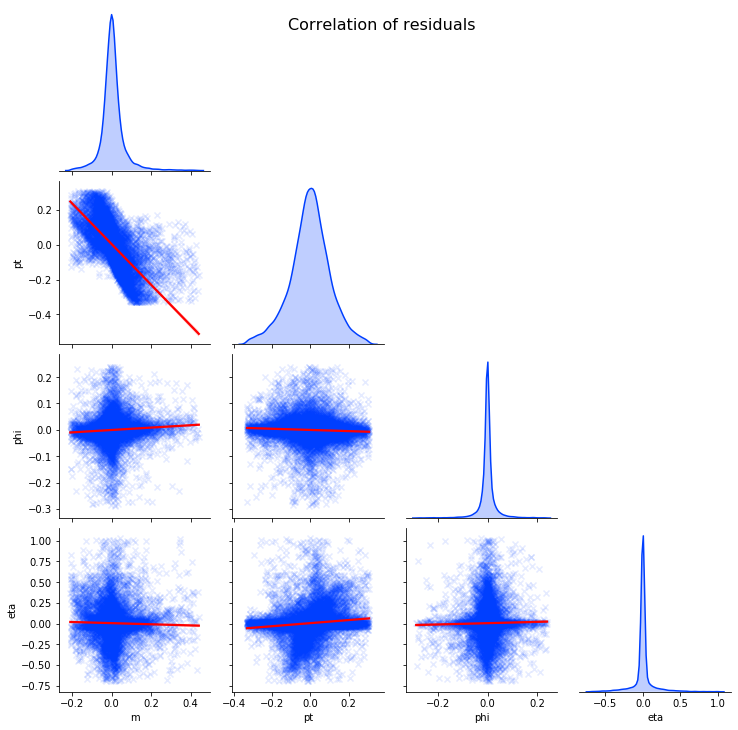

In [9]:
plot_pairplot(data=residuals_df, title='Correlation of residuals')

### 3D visualisation will give some hints to understand their relationship. (It is interactive. Try to rotate and resize)

`eta` will determine a color of one sample.<br>

Looking at this plot we can see that absolute value of residuals is bigger when `pt` and `m` are small.<br>
Also, It seems that samples with `eta` close to 3.14, -3.14 have big residual of `m`. <br>

Usually neural networks don't work well with radians because physically 3.13 and -3.13 are close to each other but for NN the distance between them is 6.26. In future I will try to firstly encode angles as sin and cos and after that do compression.

In [10]:
residuals = (reconstructed_unscaled - original_unscaled) / original_unscaled
residuals_df = pd.DataFrame(residuals, columns=feature_names)

preds_df = pd.DataFrame(reconstructed_unscaled, columns=feature_names)
preds_df['m_residual'] = residuals_df['m']

plot_3d_scatter(preds_df, x='m', y='pt', z='m_residual', color='eta')

Color is eta
